In [1]:
import copy
import random
import numpy as np  
import meshtools as mt
import meshdeform as md
import optimization as opt
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

In [2]:
# Load and set mesh file
#your_mesh = mesh.Mesh.from_file('meshes/Stanford.stl')
#your_mesh = mesh.Mesh.from_file('meshes/utah.stl')
#your_mesh = mesh.Mesh.from_file('meshes/Suzanne2.stl')
#your_mesh = mesh.Mesh.from_file('meshes/utah.stl')
your_mesh = mesh.Mesh.from_file('meshes/civ2-pc.stl')

#your_mesh = mesh.Mesh.from_file('3d_model_of_Sphere.stl')

In [3]:
points = mt.pointcloud(your_mesh)
centered_points = mt.centered(points)
svec, tvec, uvec, x0 = mt.calculatebasis(centered_points)

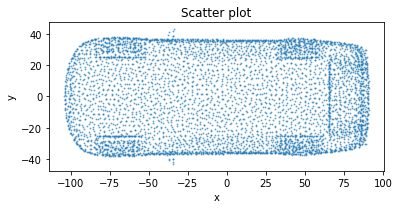

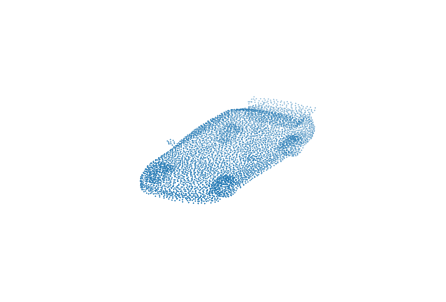

In [4]:
mt.visualize2D(centered_points,c=[1,0], sz=1)
mt.visualize3D(centered_points, sz=.25, save=False)

In [5]:
# Define number of planes
plist = [2,9,2]

# Calculate control point list
pijk = mt.controlpointmethod([svec,tvec,uvec],x0,p=plist)
p, cplist = mt.createcplist(pijk, p=plist)

#Define input base
input_base = svec,tvec,uvec, x0, plist, p

In [6]:
#shp = np.shape(p)[:-1]
#new_p = p.reshape(np.product(shp),3)
#filtered_p = np.array([p for p in new_p if p[1] not in [-73.08815574645996, 0., 24.36271858215332]])

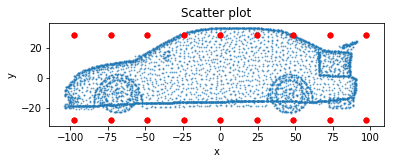

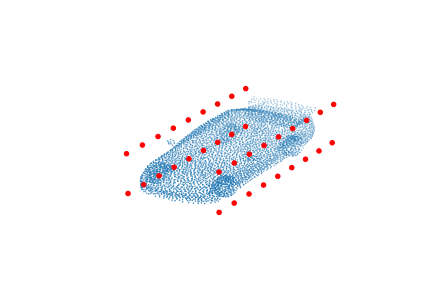

In [13]:
mt.visualizecontrolvolume2D(centered_points, cplist, c=[1,2],sz1=1, sz2=25)
mt.visualizecontrolvolume(centered_points, cplist,sz1=.25,sz2=20)
#mt.visualizecontrolvolume2D(centered_points, cplist, c=[1,0],sz1=1, sz2=25)
#mt.visualizecontrolvolume(centered_points, cplist,sz1=.25,sz2=20)

In [8]:
def selYZheightenZ(cp_in, y, z, height):
    
    xs = np.shape(cp_in)[0]
    for x in range(0,xs):
        cp_in[x][y][z] = np.array([cp_in[x][y][z][0], cp_in[x][y][z][1],  cp_in[x][y][z][2]+height])
        
def selZheightenZ(cp_in, z, height):
    
    ys = np.shape(cp_in)[1]
    for y in range(2,ys-2):
    #for y in range(3,ys-2):
        selYZheightenZ(cp_in, y, z, height)

In [9]:
def selYZwidenY(cp_in, y, z, width):
    
    xs = np.shape(cp_in)[0]
    for x in range(0,xs):
        cp_in[x][y][z] = np.array([cp_in[x][y][z][0]-(1-2*x)*width, cp_in[x][y][z][1], cp_in[x][y][z][2]])
        
def selXwidenY(cp_in, width):
    
    ys = np.shape(cp_in)[1]
    zs = np.shape(cp_in)[2]
    for y in range(2,ys-2):
    #for y in range(0,ys):
    #for y in range(3,ys-2):
        for z in range(0,zs):
            selYZwidenY(cp_in, y, z, width)

In [10]:
def deformMidsection3D(cp_in, input_x):
    
    xs, ys, zs = np.shape(cp_in)[0], np.shape(cp_in)[1], np.shape(cp_in)[2]
    
    delta = np.zeros(shape=(2,1,2,3))
    
    delta[0][0][0] = np.array([-input_x[0], 0, 0])
    delta[1][0][0] = np.array([input_x[0], 0, 0])
    delta[0][0][1] = np.array([-input_x[1], 0, input_x[2]])              
    delta[1][0][1] = np.array([input_x[1], 0, input_x[2]])                  
    
    y0 = 3
    yE = ys-2
    
    for x in range(0,xs):
        for y in range(y0,yE):
            for z in range(0,zs):

                cp_in[x][y][z] = np.array([cp_in[x][y][z][0], cp_in[x][y][z][1], cp_in[x][y][z][2]]) + delta[x][0][z]


In [11]:
#deformation_function = lambda x,y : selZheightenZ(x, 1, y[0])
#deformation_function = lambda x,y : selXwidenY(x, y[0])
#deformation_function = lambda x,y : (selXwidenY(x, y[0]), selZheightenZ(x, 1, y[1]))

In [11]:
#import time
#a = time.time()
#objective(0)
#b = time.time()
#b-a

In [31]:
#deformed_shape, deformed_cp = md.calculateDeformedMesh(centered_points, input_base, deformMidsection3D, [20,20,0])
deformed_shape, deformed_cp = md.calculateDeformedMesh(centered_points, input_base, deformMidsection3D, [0,0,20])


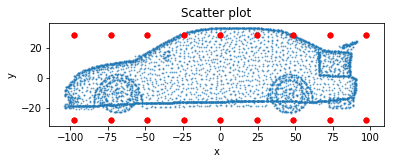

In [13]:
shp = (np.product(plist), 3)
mt.visualizecontrolvolume2D(deformed_shape, np.reshape(deformed_cp, shp), c=[1,2],sz1=1, sz2=25)

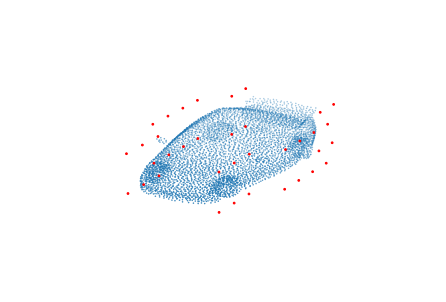

In [14]:
mt.visualizecontrolvolume(deformed_shape, np.reshape(deformed_cp, shp), sz1=.25, sz2=3)
#mt.visualize3D(deformed_shape,sz=.25,save=False)

In [15]:
import pickle

#Define target and start shape
shapes = [deformed_shape, centered_points]

#out_shapes = open('shapes2.out', 'wb')
#out_base = open('base2.out', 'wb')

#pickle.dump(shapes, out_shapes) 
#pickle.dump(input_base, out_base)

#out_shapes.close()                 
#out_base.close()

In [16]:
import time

pm = []

objective = md.buildObjectivefunction(shapes, input_base, deformMidsection3D)

#def runExperiment():
a = time.time()
popmins, pops, covs, sigmas, centroids = opt.runCMAES(objective, [0]*3, config=[10, 10, 1.0], gen=10)

pmins = [p[1] for p in popmins]
deltas = [pmins[i]-pmins[i+1] for i in range(0,len(pmins)-1)]
idx = np.argmax(deltas)

b = time.time()
print((b-a)/60)

pm.append([o[-1] for o in popmins])

12.238958160082499


In [17]:
pops[-1]

[[[6.870640165895633, 28.331791838272572, -5.061023205545089],
  4.004862503035781],
 [[28.82499998411403, 26.221358239229417, -3.490021453446218],
  4.668550335083589],
 [[15.007056191420988, 29.861643238994304, 5.19173750252051],
  5.095469036843922],
 [[2.4876876789733604, 18.587933245575694, -2.2074186602886474],
  7.335486586621167],
 [[4.672826691248606, 8.170652037467402, 4.883792129609416],
  13.10796268518268],
 [[26.262772866085093, 17.26999430677656, 13.790163453408546],
  15.67439558400514],
 [[5.402316450602465, 4.002763678268057, -1.0083628341882238],
  16.70060191720843],
 [[-2.2789500860008296, 18.56365603790294, -11.936080114798035],
  21.54299116692785],
 [[25.740267341413663, 47.005198018398, 2.508704420763908],
  22.137538561690846],
 [[18.170631146034992, -13.126369918051989, 1.2394593049338825],
  23.05629588754049]]

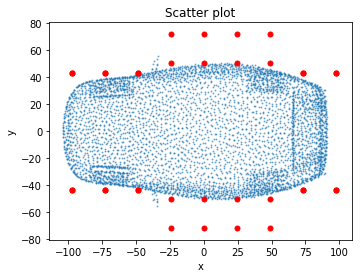

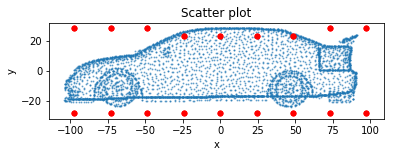

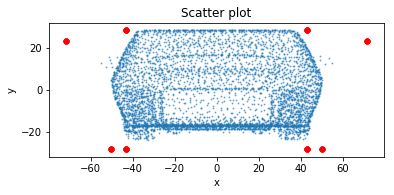

In [20]:
#deformed_shape, deformed_cp = md.calculateDeformedMesh(centered_points, input_base, deformMidsection, [20,20,20,0,20,0])
deformed_shape, deformed_cp = md.calculateDeformedMesh(centered_points, input_base, deformMidsection3D, popmins[-1][0])

shp = (np.product(plist), 3)
mt.visualizecontrolvolume2D(deformed_shape, np.reshape(deformed_cp, shp), c=[1,0],sz1=1, sz2=25)
mt.visualizecontrolvolume2D(deformed_shape, np.reshape(deformed_cp, shp), c=[1,2],sz1=1, sz2=25)
mt.visualizecontrolvolume2D(deformed_shape, np.reshape(deformed_cp, shp), c=[0,2],sz1=1, sz2=25)


In [27]:
pm2 = []

a = time.time()
popmins2, pops2, _, _, centroids2 = opt.runCMAES(objective, [0]*3, config=[10, 10, 1], gen=3)
popmins3, _, _, _, _ = opt.runCMAES(objective, centroids[2], config=[10, 10, sigmas[idx]], gen=10-3, cmat=covs[idx])
b = time.time()
print((b-a)/60)


pm2.append([o[-1] for o in (popmins2+popmins3)])

14.190844134489696


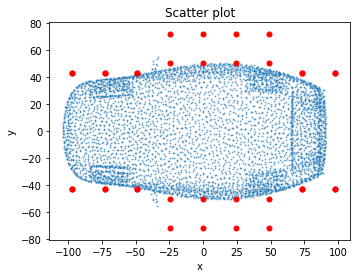

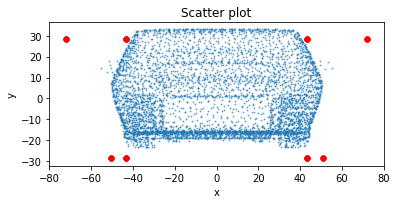

In [28]:
#deformed_shape, deformed_cp = md.calculateDeformedMesh(centered_points, input_base, deformMidsection, [20,20,20,0,20,0])
deformed_shape, deformed_cp = md.calculateDeformedMesh(centered_points, input_base, deformMidsection3D, popmins3[-1][0])

shp = (np.product(plist), 3)
mt.visualizecontrolvolume2D(deformed_shape, np.reshape(deformed_cp, shp), c=[1,0],sz1=1, sz2=25)
mt.visualizecontrolvolume2D(deformed_shape, np.reshape(deformed_cp, shp), c=[0,2],sz1=1, sz2=25)

In [29]:
med1 = np.median(pm[:], axis=0)
med2 = np.median(pm2[:], axis=0)

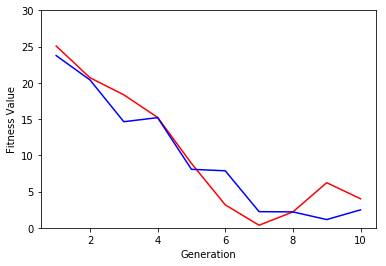

In [30]:
import matplotlib.pyplot as plt


ylmt=[0,30]
x = np.array(range(1,1+len(med1)))

plt.figure()
plt.ylim(ylmt[0],ylmt[1])
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.plot(x, med1, 'red')
#plt.plot(x, np.array(pm[:]).T, 'red', alpha=.25)
plt.plot(x, med2, 'blue')
#plt.plot(x, np.array(pm2[:]).T, 'lightblue', alpha=.25)
#plt.plot(x, np.array(pm2[10:20]).T, 'green', alpha=1.)



plt.show()

In [127]:
np.argmin([p[1] for p in popmins2])

3

In [121]:
popmins2[-1][0]

[29.989525434162232, 6.334837196886962, 1.3373141230221108]